In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from dataloader import xr_standardize_field

import torch.nn as nn
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch
from prep_gan import find_nearest_index, to_utc

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator


import matplotlib.pyplot as plt

plt.style.use(['science','no-latex'])
plt.rcParams.update({"figure.figsize":  (5,10),
                    'font.family': 'Times New Roman',
                    'font.size': 25,
                    'lines.linewidth': 2.5})


from models.generator import Generator
from models.critic import Critic
# import geopandas as gpd

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

In [2]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=4, threads_per_worker=1, memory_limit="4GB")
client

Client Scheduler: tcp://127.0.0.1:40943 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 14.90 GiB


In [3]:
hr_dataroot_U10 = "data/wrf/U10/regrid_10_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "data/wrf/V10/regrid_10_6hrly_wrf2d_d01_ctrl_V10*.nc"

hr_dataroot_U10 = "data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc"

fine_u = xr.open_mfdataset(glob.glob(hr_dataroot_U10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})
fine_v = xr.open_mfdataset(glob.glob(hr_dataroot_V10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})

dataroot = "./data/interim_2000-10-01_to_2013-09-30.nc"

target = '10UV_GDS4_SFC'
coarse = xr.open_dataset(dataroot).astype("float")
coarse = coarse.sortby('latitude', ascending=True)
coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

# scale factor
sf = 8

In [4]:
# low, up, l, r = 9, 19, 75, 85
low, up, l, r = 4, 20, 70, 86

In [5]:
u10 = fine_u.U10[1:, sf*low:sf*up, sf*l:sf*r]
v10 = fine_v.V10[1:, sf*low:sf*up, sf*l:sf*r]

coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

coarse_u10_patch = coarse_u10[1:, low:up, l:r]
coarse_v10_patch = coarse_v10[1:, low:up, l:r]

u10 = xr_standardize_field(u10)
v10 = xr_standardize_field(v10)
coarse_u10 =  xr_standardize_field(coarse_u10_patch)
coarse_v10 =  xr_standardize_field(coarse_v10_patch)

In [6]:
# coarse_u10[18, ...].values
u10

<xarray.DataArray 'U10' (Times: 18991, lat: 128, lon: 128)>
dask.array<truediv, shape=(18991, 128, 128), dtype=float32, chunksize=(10, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
  * lon      (lon) float32 -86.55 -86.46 -86.37 -86.27 ... -74.84 -74.74 -74.65
  * lat      (lat) float32 21.14 21.23 21.32 21.42 ... 32.76 32.86 32.95 33.04

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


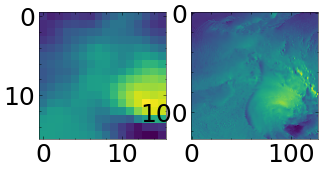

In [7]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [8]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

In [9]:
fine_t = torch.from_numpy(fine)#.double()
coarse_t = torch.from_numpy(coarse)#.double()

In [10]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine#.to(device)
        self.coarse = coarse#.to(device)

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]

#         arr = torch.unsqueeze(arr, 0)
#         carr = torch.unsqueeze(carr, 0)

#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr

dataset = NetCDFSR(
    fine_t,
    coarse_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

real_batch, real_cbatch = next(iter(dataloader))
fixed = {"coarse": real_cbatch, "fine": real_batch}
fixed["coarse"].size()

torch.Size([64, 2, 16, 16])

In [11]:
# from models import Generator, Discriminator
# G = Generator(10, 100, 2).double()

In [12]:
import mlflow
logged_model = 'file:///home/nannau/msc/DoWnGAN/mlruns/1/894f3ebbd4384c40aaa0a3d2dd0789d7/artifacts/Generator'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
G = mlflow.pytorch.load_model(logged_model).to(device)

# state_dict_uri = mlflow.get_artifact_uri(artifact_path)
state_dict = mlflow.pytorch.load_state_dict("/home/nannau/msc/DoWnGAN/mlruns/1/894f3ebbd4384c40aaa0a3d2dd0789d7/artifacts/Generator/")#state_dict.pth")
G.load_state_dict(state_dict)
# loaded_model(fixed["coarse"].to(device))

<All keys matched successfully>

In [13]:
# state = torch.load("checkpoints/losses/20210331-235010")
# state = torch.load("checkpoints/losses/20210423-230231")
# state = torch.load("checkpoints/losses/20210424-163047")
# state = torch.load("checkpoints/losses/20210424-095749")
# state = torch.load("checkpoints/losses/20210427-124527") # Structural loss with amplified trailing EOFs
# state = torch.load("checkpoints/losses/20210427-183446")
# state = torch.load("checkpoints/losses/20210427-231215") # Structural loss without amplified trailing EOFs
# state = torch.load("checkpoints/losses/20210428-013842") # No EOFs
# state = torch.load("checkpoints/losses/20210428-111811") # No EOFs
# state = torch.load("checkpoints/losses/20210513-100115") # No EOFs
# state = torch.load("checkpoints/losses/20210517-033357")

In [14]:
# G.load_state_dict(state["generator"])

In [15]:
coarse_t.size()

torch.Size([18991, 2, 16, 16])

In [16]:
batch_size=64
i = np.random.randint(0, batch_size)
# fake = G(fixed["coarse"])[i, 0, ...]
# real = fixed["fine"].detach().numpy()[i, 0, ...]
# coarse = fixed["coarse"].detach().numpy()[i, 0, ...]

In [17]:
# fake.detach().numpy()
real = fixed["fine"][i, 1, ...].detach().numpy()
coarse = fixed["coarse"][i, 1, ...].detach().numpy()

Text(0.5, 1.0, 'Ground Truth')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


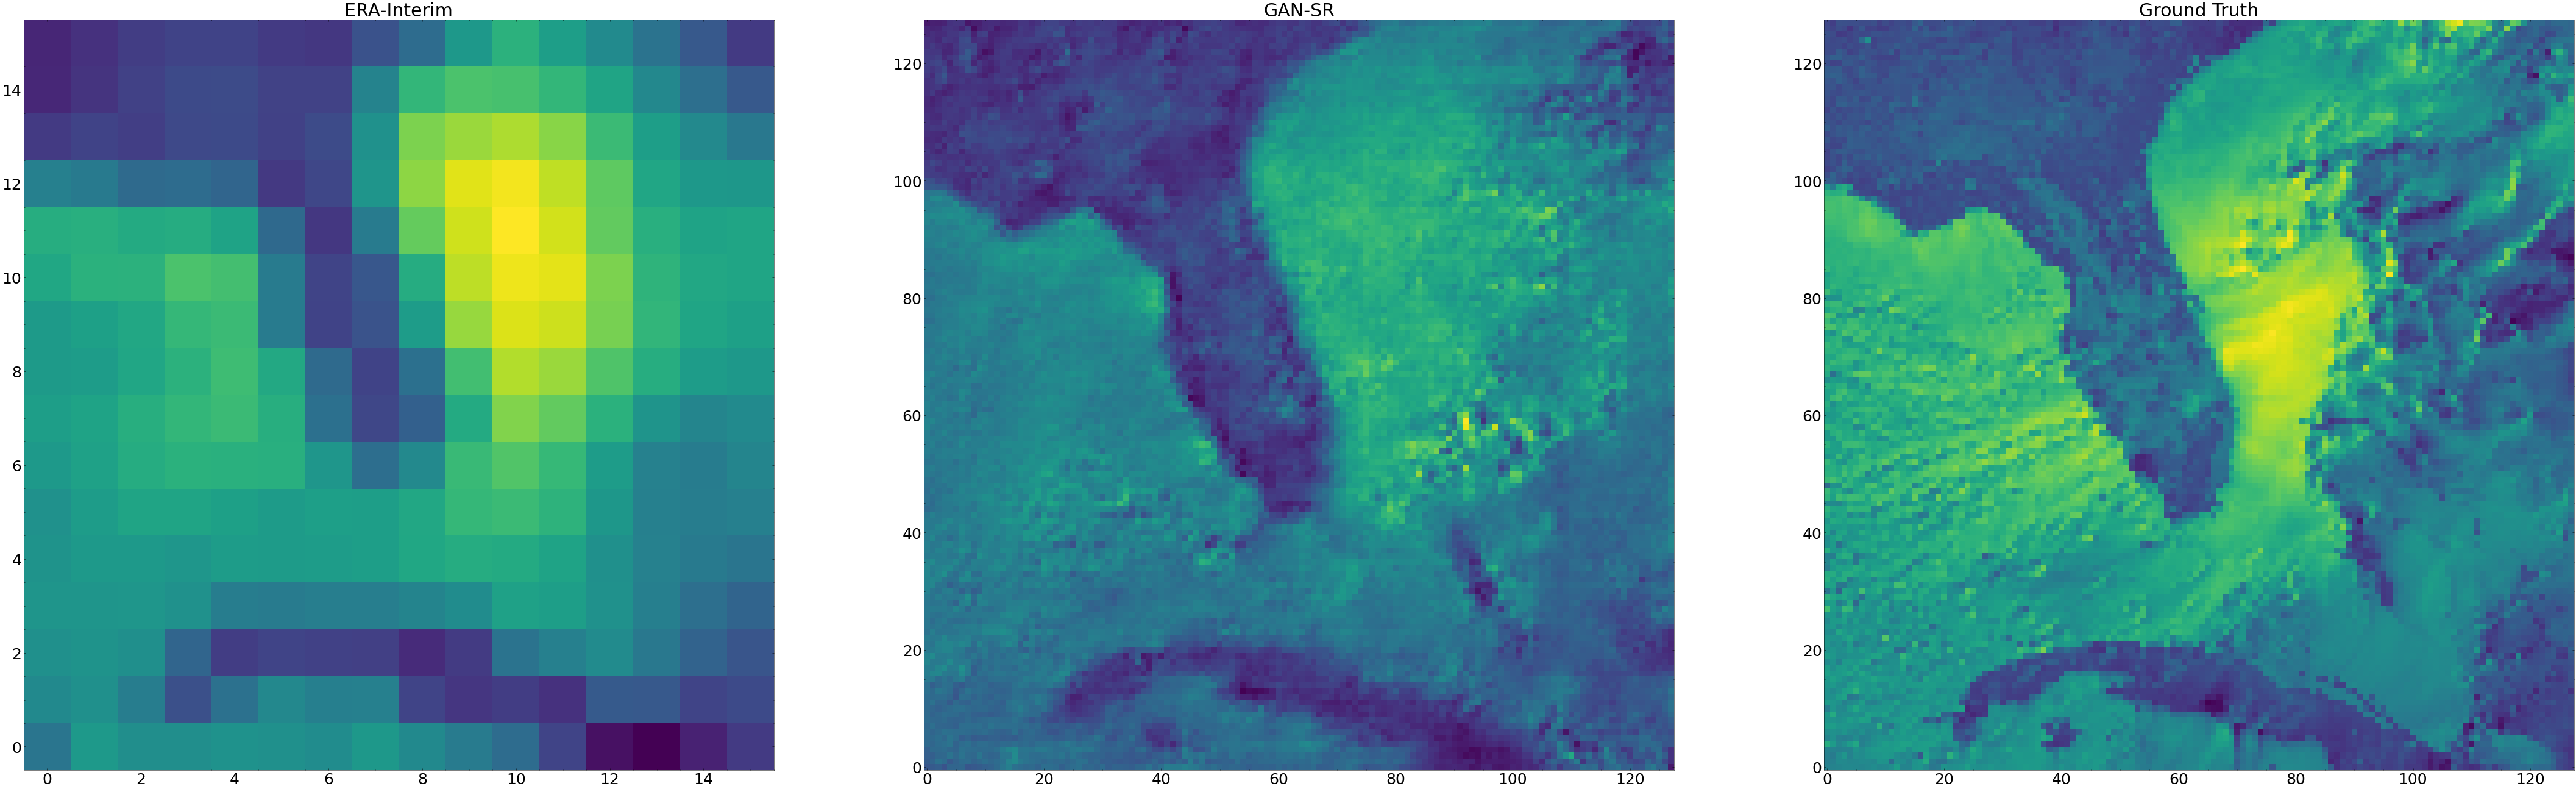

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(75, 75))
# np.random.seed(500)
i = np.random.randint(0, batch_size)

N1 = 3
N2 = N1+3
    
# i = np.random.randint(0, batch_size)

# real = fixed["fine"][i, 1, ...].detach().numpy()
# coarse = fixed["coarse"][i, 1, ...].detach().numpy()

coarse_hypot = np.hypot(
    fixed["coarse"][i, 0, ...].detach().numpy(),
    fixed["coarse"][i, 1, ...].detach().numpy()
)

u10_fake = G(fixed["coarse"].float().to(device))[i, 0, ...].detach().cpu().numpy()
v10_fake = G(fixed["coarse"].float().to(device))[i, 1, ...].detach().cpu().numpy()

real = fixed["fine"][i, 1, ...].detach().numpy()

u10_real = fixed["fine"][i, 0, ...].detach().numpy()
v10_real = fixed["fine"][i, 1, ...].detach().numpy()

speed_fake = np.hypot(u10_fake, v10_fake)
speed_real = np.hypot(u10_real, v10_real)

#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)

# Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)

ax[0].imshow(coarse_hypot, origin="lower")
ax[0].set_title("ERA-Interim")
ax[1].imshow(speed_fake, origin="lower")
ax[1].set_title("GAN-SR")
ax[2].imshow(speed_real, origin="lower")
ax[2].set_title("Ground Truth")

In [ ]:
# PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# fine_pca = fine.reshape(fine.shape[0], fine.shape[1]*fine.shape[2])
# pca = PCA(n_components=250)
# pca.fit(fine_pca)

# ncomp = pca.components_.shape[0]
# fine_sp_basis = pca.components_.reshape(ncomp, fine.shape[1]*fine.shape[2])
# fine_sp_basis.shape

# PCA
ncomp = 5
fine_pca_u10 = np.array(u10).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_u10)
fine_sp_basis_u10 = pca.components_.reshape(ncomp, u10.shape[1]*u10.shape[2])

fine_pca_v10 = np.array(v10).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_v10)
fine_sp_basis_v10 = pca.components_.reshape(ncomp, v10.shape[1]*v10.shape[2])

fine_sp_basis = np.stack([fine_sp_basis_u10, fine_sp_basis_v10], axis=1)

In [19]:
from scipy.interpolate import interp2d
x = np.arange(coarse.shape[0])
y = np.arange(coarse.shape[1])
nx = np.linspace(x.min(), x.max(), sf*x.shape[0])
ny = np.linspace(y.min(), y.max(), sf*y.shape[0])

In [20]:
# u10_mean = float(np.mean(coarse_u10))
# v10_mean = float(np.mean(coarse_v10))
# u10_std = float(np.std(coarse_u10))
# v10_std = float(np.std(coarse_v10))
# u10_mean

In [ ]:
u10mse, v10mse, uv10mse = [], [], []
for k in range(63):
    u10_fake = G(fixed["coarse"]).detach().numpy()[k, 0, ...]
    v10_fake = G(fixed["coarse"]).detach().numpy()[k, 1, ...]

    real = fixed["fine"].detach().numpy()[k, 1, ...]

    u10_real = fixed["fine"].detach().numpy()[k, 0, ...]
    v10_real = fixed["fine"].detach().numpy()[k, 1, ...]

    speed_fake = np.hypot(u10_fake*u10_std+u10_mean, v10_fake*v10_std+v10_mean)
    speed_real = np.hypot(u10_real*u10_std+u10_mean, v10_real*v10_std+v10_mean)
    
    uv10mse.append(mean_squared_error(speed_fake, speed_real))
    u10mse.append(mean_squared_error(u10_fake, u10_real))
    v10mse.append(mean_squared_error(v10_fake, v10_real))

In [ ]:
plt.plot(range(63), u10mse)

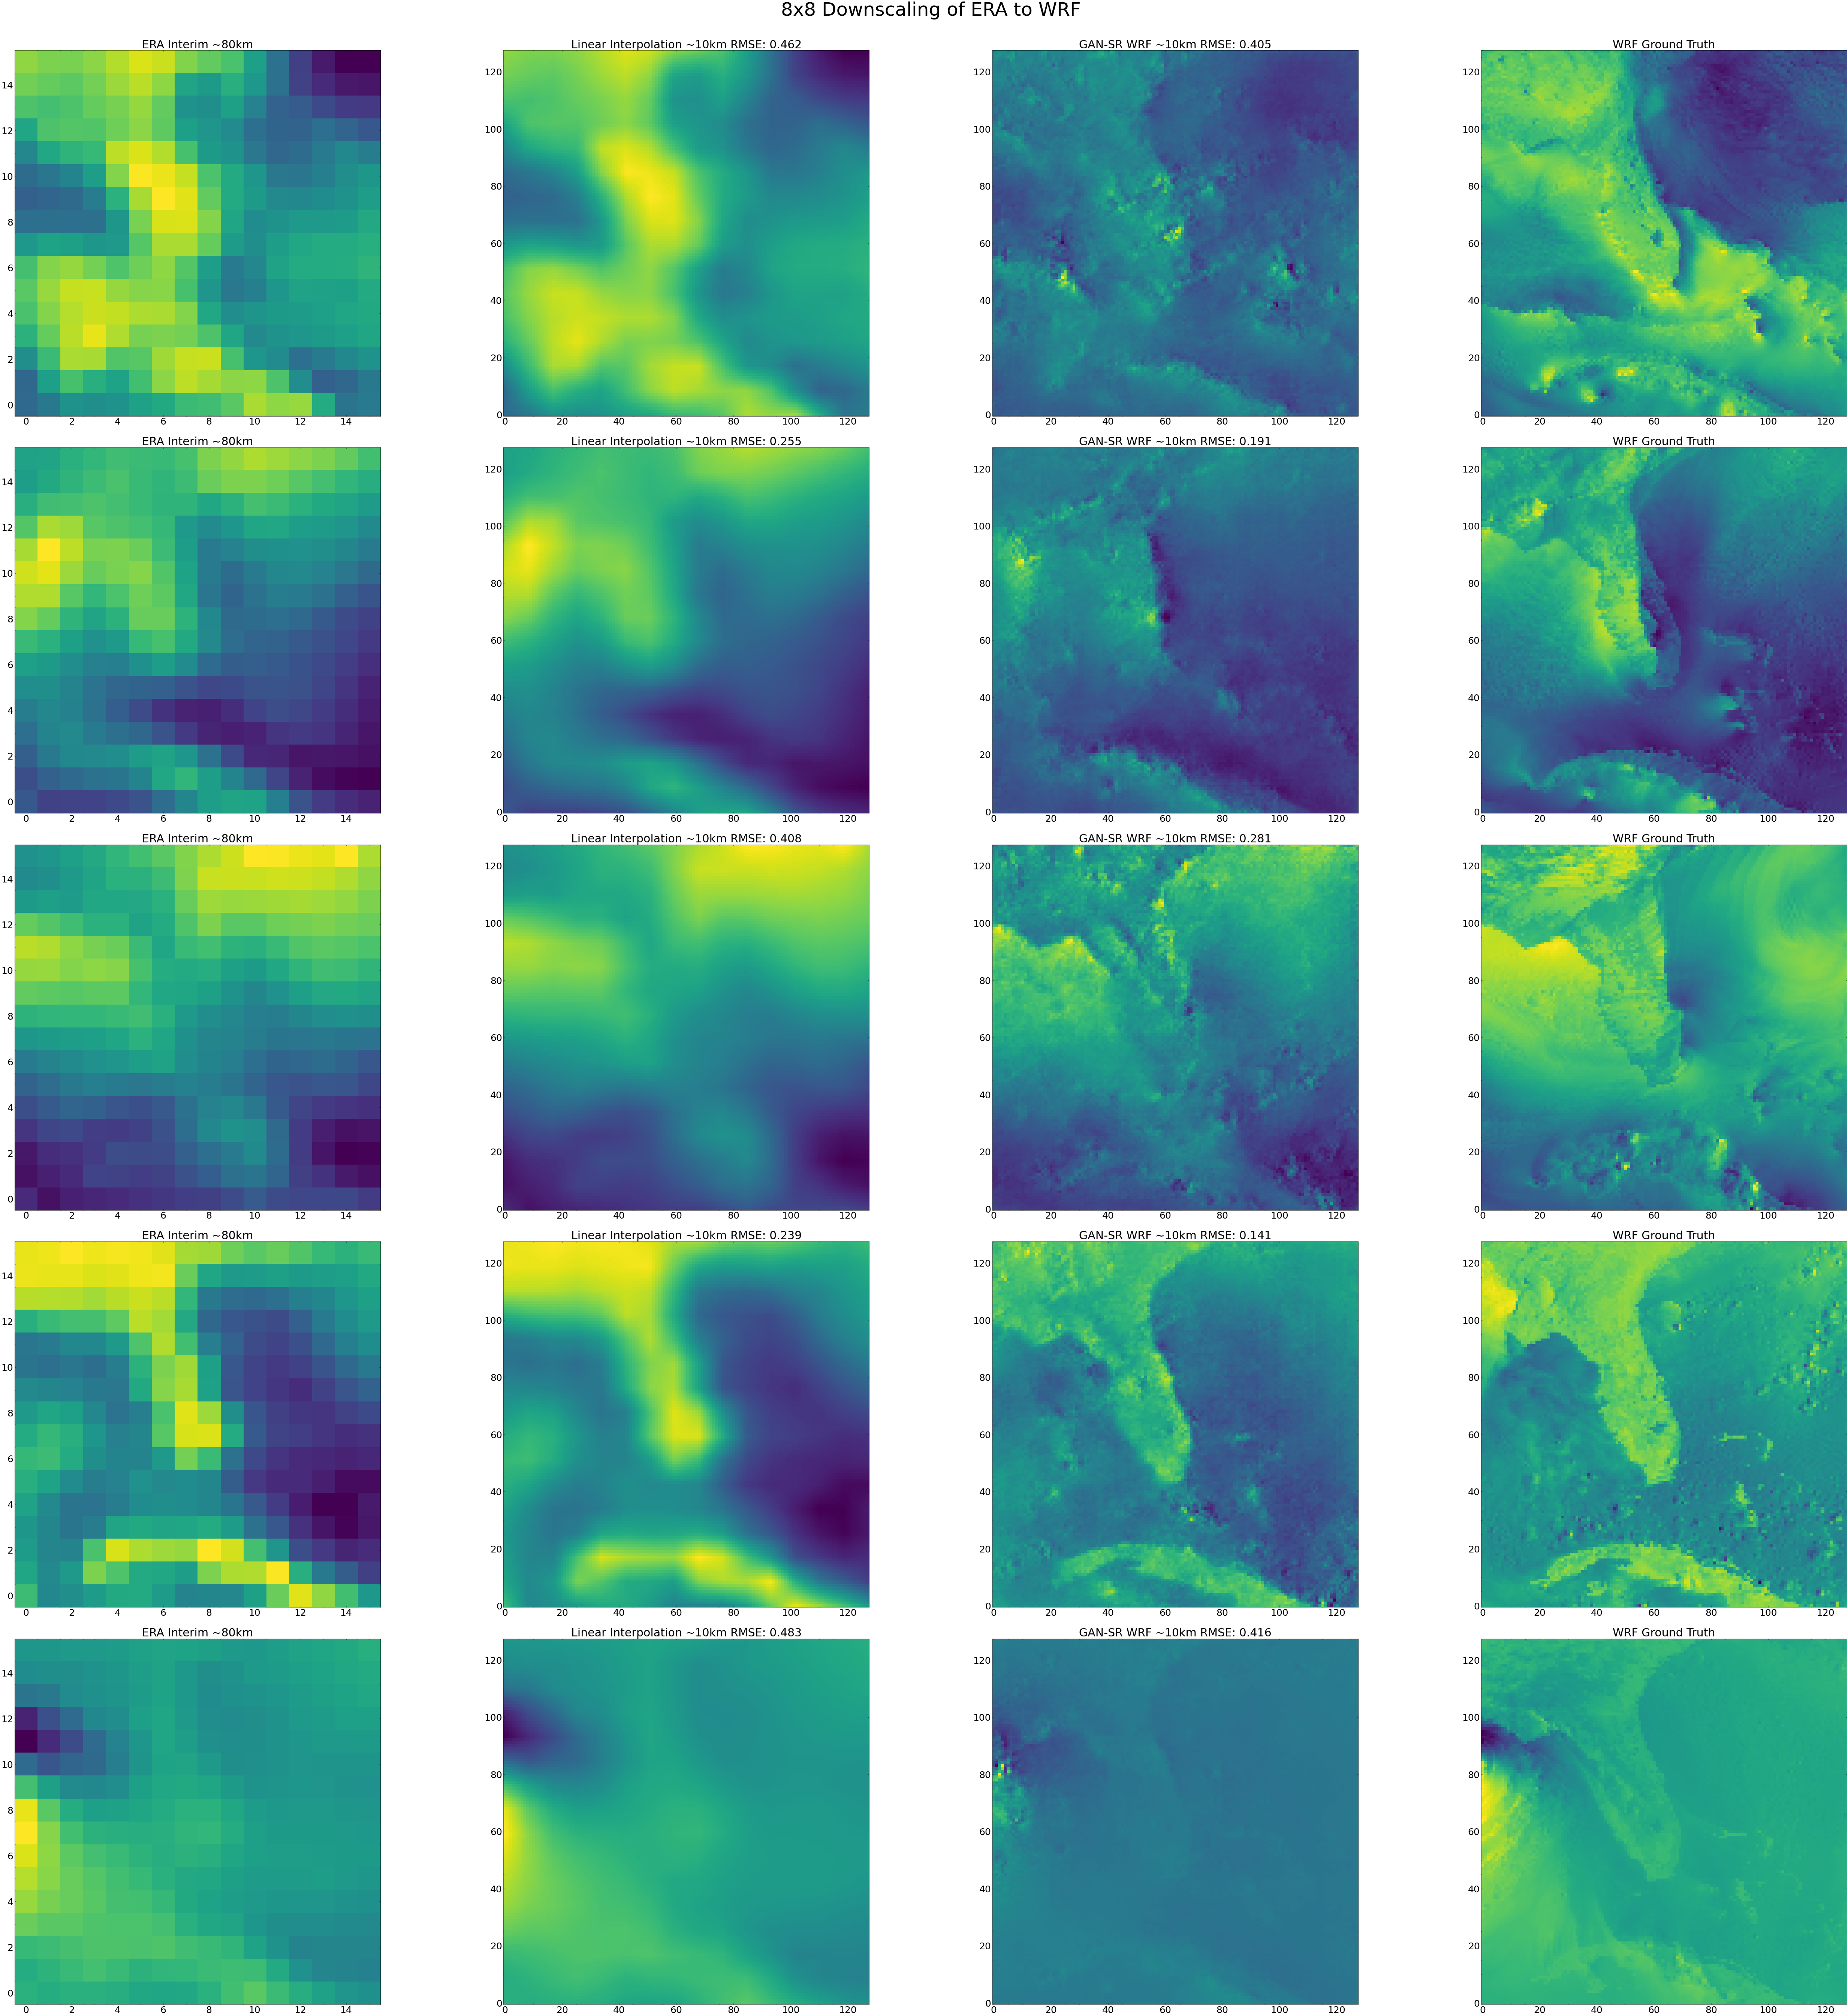

In [33]:
from scipy.interpolate import interp2d

fig, ax = plt.subplots(5, 4, figsize=(75, 75))
np.random.seed(42)
for j in range(5):
    
    i = np.random.randint(0, batch_size)

    fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
    real = fixed["fine"].detach().numpy()[i, 0, ...]
    coarse = fixed["coarse"].detach().numpy()[i, 0, ...]
    
    flin = interp2d(x, y, coarse, kind='linear')
    naive_lin = flin(nx, ny)
    mse_naive = mean_squared_error(naive_lin.flatten(), real.flatten())
    mse_fake = mean_squared_error(fake.flatten(), real.flatten())
    
    # Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_u10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_u10.T).reshape(real.shape)
    
    
    ax[j, 0].imshow(coarse, origin="lower")
    ax[j, 0].set_title(f"ERA Interim ~80km")
    ax[j, 1].imshow(naive_lin, origin="lower")
    ax[j, 1].set_title(f"Linear Interpolation ~10km RMSE: {mse_naive:.3f}")
    ax[j, 2].imshow(fake, origin="lower")
    ax[j, 2].set_title(f"GAN-SR WRF ~10km RMSE: {mse_fake:.3f}")
#     ax[j, 3].imshow(leading_eofs)
#     ax[j, 3].set_title(f"Leading {ncomp} EOFs Linearly Regressed Against Ground Truth")
    ax[j, 3].imshow(real, origin="lower")
    ax[j, 3].set_title("WRF Ground Truth")

fig.suptitle('8x8 Downscaling of ERA to WRF', fontsize=50, y=1)
plt.tight_layout()
plt.savefig(f"artifacts/sis_gan_grid_equal_weights_extended_loss_{i}.png", facecolor='white')

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(75, 75))
np.random.seed(500)
N1 = 3
N2 = N1+3
for j in range(3):
    
    i = np.random.randint(0, batch_size)

    fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]
    real = fixed["fine"].detach().numpy()[i, 1, ...]
    coarse = fixed["coarse"].detach().numpy()[i, 1, ...]
    coarse_hypot = np.hypot(fixed["coarse"].detach().numpy()[i, 0, ...], fixed["coarse"].detach().numpy()[i, 1, ...])
    
    u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
    v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]

    real = fixed["fine"].detach().numpy()[i, 1, ...]

    u10_real = fixed["fine"].detach().numpy()[i, 0, ...]
    v10_real = fixed["fine"].detach().numpy()[i, 1, ...]

    speed_fake = np.hypot(u10_fake, v10_fake)
    speed_real = np.hypot(u10_real, v10_real)
    
#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)
    
    # Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)

    ax[j, 0].imshow(coarse_hypot, origin="lower")
    ax[j, 0].set_title("Artificially Coarsened LR")
    ax[j, 1].imshow(speed_fake, origin="lower")
    ax[j, 1].set_title("GAN-SR")
    ax[j, 2].imshow(speed_real, origin="lower")
    ax[j, 2].set_title("Ground Truth")

fig.suptitle('Speed 4x4 Downscaling of ERA Interm Surface Wind Magnitudes with 850 Epochs', fontsize=50, y=0.9)
plt.savefig(f"sisr_gan_grid_gradient_loss_{ncomp}_speed_{i}.png", facecolor='white')

In [26]:
N = 2704
N_epochs = 450
r = N/N_epochs
a = 27
(1/a)*N



100.14814814814814